In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.parse
import re
import numpy as np
import seaborn as sns
import ast
from wordcloud import WordCloud, STOPWORDS
import sklearn
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.feature_selection import SelectFromModel
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.over_sampling import ADASYN

In [ ]:
df = pd.read_parquet('/content/drive/My Drive/clinical trials/completion_model_embeddings.parquet')
df

,identificationModule_nctId,eligibilityModule_minimumAge,eligibilityModule_maximumAge,designModule_enrollmentInfo_count,leadsponsor_FED,leadsponsor_INDUSTRY,leadsponsor_NETWORK,leadsponsor_NIH,leadsponsor_OTHER,leadsponsor_OTHER_GOV,...,Inorganic Chemicals,Biological Factors,Carbohydrates,Pharmaceutical Preparations,Complex Mixtures,"Nucleic Acids, Nucleotides, and Nucleosides",Biomedical and Dental Materials,Macromolecular Substances,combined_description,cls_embedding
0,NCT05353218,18.0,100.0,80.0,False,False,False,False,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cervical plexus blocks are regional methods us...,"[-0.22635674, -0.13854223, 0.25579327, 0.51314..."
1,NCT05713162,8.0,17.0,94.0,False,False,False,False,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Research evaluating effectiveness of social sk...,"[0.16108948, 0.03251096, -0.17350686, 0.559933..."
2,NCT01707277,0.0,100.0,26.0,False,False,False,False,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Previous studies have evaluated the effects of...,"[0.27022436, -0.121417575, 0.29181343, 0.28107..."
3,NCT02953301,18.0,100.0,201.0,False,True,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,The purpose of this study is to determine whet...,"[0.21312869, -0.121839024, 0.2649881, 0.065689..."
4,NCT05921591,18.0,55.0,24.0,False,True,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,The purpose of this clinical study is to asses...,"[0.13091025, 0.2669704, 0.12406835, 0.04409665..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263443,NCT03914846,18.0,100.0,47.0,False,False,False,False,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,This trial studies the use of a novel non-inva...,"[-0.16493556, -0.5514333, 0.14829694, 0.564059..."
263444,NCT01967940,18.0,100.0,55.0,False,True,False,False,False,False,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,The primary objective of this study is to eval...,"[-0.3917277, -0.30124602, 0.31587094, 0.429657..."
263445,NCT03986086,18.0,80.0,0.0,False,False,False,False,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,The purpose of this study is evaluate the safe...,"[-0.31064114, -0.11172508, 0.23755355, 0.49358..."
263446,NCT00254020,18.0,100.0,138.0,False,False,False,False,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Depression is a common and often serious probl...,"[-0.04641965, -0.11021524, 0.23101763, 0.81247..."


In [ ]:
df['status_binary'] = (df['statusModule_overallStatus'] == 'COMPLETED').astype(int)
print(df['status_binary'].value_counts())

df = df.drop(columns = ['identificationModule_nctId','statusModule_overallStatus', 'combined_description'])

status_binary
1    223519
0     39929
Name: count, dtype: int64


In [ ]:
# === Step 1: Prepare Data ===
df_run = df.copy()
#desired_ratio = 0.5  # for undersampling, means 1:2 ratio

# Separate features and target
X_full = df_run.drop(columns=['status_binary'])
y_full = df_run['status_binary']

# --- Step 2: Train-test split (BEFORE sampling) ---
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# --- Step 3: Perform Sampling ONLY on training set ---
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# =======================
# --- Choose sampler ---
# =======================
# Option 1: Undersampling (commented out)
# rus = RandomUnderSampler(sampling_strategy=desired_ratio, random_state=42)
# X_train_resampled, y_train_resampled = rus.fit_resample(X_train_full, y_train)

# Option 2: Oversampling (default)
ros = RandomOverSampler(sampling_strategy=0.8, random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_full, y_train)

# --- Step 4: PCA on cls_embedding (TRAIN ONLY) ---
embeddings_matrix_train = np.vstack(X_train_resampled['cls_embedding'].values)
embeddings_matrix_train = StandardScaler().fit_transform(embeddings_matrix_train)

pca = PCA()
pca.fit(embeddings_matrix_train)
optimal_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Optimal PCA components: {optimal_components}")

pca = PCA(n_components=optimal_components)
reduced_embeddings_train = pca.fit_transform(embeddings_matrix_train)
reduced_embeddings_train = StandardScaler().fit_transform(reduced_embeddings_train)
df_pca_train = pd.DataFrame(reduced_embeddings_train, columns=[f'pca_emb_{{i}}' for i in range(optimal_components)])
df_pca_train.index = X_train_resampled.index

# --- Step 5: Apply PCA Transform to Test Set ---
embeddings_matrix_test = np.vstack(X_test_full['cls_embedding'].values)
embeddings_matrix_test = StandardScaler().fit_transform(embeddings_matrix_test)
reduced_embeddings_test = pca.transform(embeddings_matrix_test)
df_pca_test = pd.DataFrame(reduced_embeddings_test, columns=[f'pca_emb_{{i}}' for i in range(optimal_components)])
df_pca_test.index = X_test_full.index

# --- Step 6: Tabular features preprocessing ---
for df_part in [X_train_resampled, X_test_full]:
    df_part.drop(columns=['cls_embedding'], inplace=True)
    numerical_features = [col for col in df_part.columns if df_part[col].dtype in [np.float64, np.int64]]
    dummy_features = [col for col in df_part.columns if col not in numerical_features]
    for col in dummy_features:
        if df_part[col].dtype == 'bool':
            df_part[col] = df_part[col].astype(int)

# --- Step 7: Fit Scaler on Train, Transform Test ---
scaler = MinMaxScaler()
X_train_resampled[numerical_features] = scaler.fit_transform(X_train_resampled[numerical_features])
X_test_full[numerical_features] = scaler.transform(X_test_full[numerical_features])

# --- Step 8: Prepare tensors ---
X_tab_train_np = X_train_resampled.values.astype(np.float32)
X_emb_train_np = df_pca_train.values.astype(np.float32)
y_train_np = y_train_resampled.values.astype(np.float32)

X_tab_test_np = X_test_full.values.astype(np.float32)
X_emb_test_np = df_pca_test.values.astype(np.float32)
y_test_np = y_test.values.astype(np.float32)

X_tab_train = torch.tensor(X_tab_train_np)
X_emb_train = torch.tensor(X_emb_train_np)
y_train = torch.tensor(y_train_np)

X_tab_test = torch.tensor(X_tab_test_np)
X_emb_test = torch.tensor(X_emb_test_np)
y_test = torch.tensor(y_test_np)

# --- Step 9: Validation split ---
X_tab_train, X_tab_val, X_emb_train, X_emb_val, y_train, y_val = train_test_split(
    X_tab_train, X_emb_train, y_train, test_size=0.1, random_state=42
)

# --- Step 10: DataLoaders ---
train_ds = TensorDataset(X_tab_train, X_emb_train, y_train)
val_ds = TensorDataset(X_tab_val, X_emb_val, y_val)
test_ds = TensorDataset(X_tab_test, X_emb_test, y_test)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

# === Step 5: Define Dual-Tower Model ===
class DualTowerNN(nn.Module):
    def __init__(self, tabular_input_dim, emb_input_dim, hidden_dim=64, dropout_rate=0.3):
        super(DualTowerNN, self).__init__()

        # MLP for tabular features
        self.tabular_net = nn.Sequential(
            nn.Linear(tabular_input_dim, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(dropout_rate),
            nn.Linear(32, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # MLP for embedding features
        self.embedding_net = nn.Sequential(
            nn.Linear(emb_input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1)
            # No Sigmoid here — use BCEWithLogitsLoss!
        )

    def forward(self, x_tab, x_emb):
        tab = self.tabular_net(x_tab)
        emb = self.embedding_net(x_emb)
        combined = torch.cat([tab, emb], dim=1)
        return self.classifier(combined).squeeze(1)

# === Step 3: Train with Early Stopping ===
model = DualTowerNN(X_tab_train.shape[1], X_emb_train.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

best_val_auc = 0
epochs_no_improve = 0
patience = 5
best_model_state = None
loss_history = []

for epoch in range(100):
    model.train()
    total_loss = 0
    for x_tab_batch, x_emb_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_tab_batch, x_emb_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loss_history.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_probs, val_labels = [], []
    with torch.no_grad():
        for x_tab_val_batch, x_emb_val_batch, y_val_batch in val_loader:
            probs = model(x_tab_val_batch, x_emb_val_batch).squeeze()
            val_probs.extend(probs.tolist())
            val_labels.extend(y_val_batch.tolist())
    val_auc = roc_auc_score(val_labels, val_probs)
    scheduler.step(val_auc)
    print(f"Epoch {epoch+1} - Train Loss: {total_loss / len(train_loader):.4f} - Val AUC: {val_auc:.4f}")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

if best_model_state:
    model.load_state_dict(best_model_state)


# === Step 6: Final Evaluation ===

model.eval()
val_probs, val_labels = [], []
with torch.no_grad():
    for x_tab_val_batch, x_emb_val_batch, y_val_batch in val_loader:
        logits = model(x_tab_val_batch, x_emb_val_batch)
        probs = torch.sigmoid(logits).squeeze()
        val_probs.extend(probs.tolist())
        val_labels.extend(y_val_batch.tolist())

# Step 2: Calculate optimal threshold using validation PR curve
precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)  # avoid division by zero
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold from PR-curve: {optimal_threshold:.4f}")
print(f"Threshold range: min={thresholds.min():.4f}, max={thresholds.max():.4f}")

# Step 3: Apply optimal threshold on the TEST set
all_preds, all_probs, all_labels = [], [], []
with torch.no_grad():
    for x_tab_batch, x_emb_batch, y_batch in test_loader:
        logits = model(x_tab_batch, x_emb_batch)
        probs = torch.sigmoid(logits).squeeze()
        preds = (probs > optimal_threshold).float()
        all_preds.extend(preds.tolist())
        all_probs.extend(probs.tolist())
        all_labels.extend(y_batch.tolist())

print("\n=== Final Evaluation on Test Set ===")
print(classification_report(all_labels, all_preds))
print(f"ROC AUC Score: {roc_auc_score(all_labels, all_probs):.4f}")

Optimal PCA components: 318
Epoch 1 - Train Loss: 0.5935 - Val AUC: 0.7735
Epoch 2 - Train Loss: 0.5685 - Val AUC: 0.7913
Epoch 3 - Train Loss: 0.5538 - Val AUC: 0.8056
Epoch 4 - Train Loss: 0.5434 - Val AUC: 0.8133
Epoch 5 - Train Loss: 0.5374 - Val AUC: 0.8182
Epoch 6 - Train Loss: 0.5322 - Val AUC: 0.8201
Epoch 7 - Train Loss: 0.5284 - Val AUC: 0.8230
Epoch 8 - Train Loss: 0.5266 - Val AUC: 0.8272
Epoch 9 - Train Loss: 0.5227 - Val AUC: 0.8266
Epoch 10 - Train Loss: 0.5210 - Val AUC: 0.8308
Epoch 11 - Train Loss: 0.5181 - Val AUC: 0.8312
Epoch 12 - Train Loss: 0.5174 - Val AUC: 0.8325
Epoch 13 - Train Loss: 0.5151 - Val AUC: 0.8340
Epoch 14 - Train Loss: 0.5140 - Val AUC: 0.8351
Epoch 15 - Train Loss: 0.5145 - Val AUC: 0.8343
Epoch 16 - Train Loss: 0.5129 - Val AUC: 0.8369
Epoch 17 - Train Loss: 0.5128 - Val AUC: 0.8357
Epoch 18 - Train Loss: 0.5121 - Val AUC: 0.8375
Epoch 19 - Train Loss: 0.5110 - Val AUC: 0.8382
Epoch 20 - Train Loss: 0.5098 - Val AUC: 0.8397
Epoch 21 - Train Loss

In [ ]:
# === Step 1: Prepare Data ===
df_run = df.copy()

# Separate features and target
X_full = df_run.drop(columns=['status_binary'])
y_full = df_run['status_binary']

# --- Step 2: Train-test split (BEFORE sampling) ---
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# --- Step 3: Perform Sampling ONLY on training set ---
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# =======================
# Oversampling (default)
ros = RandomOverSampler(sampling_strategy=0.6, random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_full, y_train)

# --- Step 4: PCA on cls_embedding (TRAIN ONLY) ---
embeddings_matrix_train = np.vstack(X_train_resampled['cls_embedding'].values)
embeddings_matrix_train = StandardScaler().fit_transform(embeddings_matrix_train)

pca = PCA()
pca.fit(embeddings_matrix_train)
optimal_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Optimal PCA components: {optimal_components}")

pca = PCA(n_components=optimal_components)
reduced_embeddings_train = pca.fit_transform(embeddings_matrix_train)
reduced_embeddings_train = StandardScaler().fit_transform(reduced_embeddings_train)
df_pca_train = pd.DataFrame(reduced_embeddings_train, columns=[f'pca_emb_{{i}}' for i in range(optimal_components)])
df_pca_train.index = X_train_resampled.index

# --- Step 5: Apply PCA Transform to Test Set ---
embeddings_matrix_test = np.vstack(X_test_full['cls_embedding'].values)
embeddings_matrix_test = StandardScaler().fit_transform(embeddings_matrix_test)
reduced_embeddings_test = pca.transform(embeddings_matrix_test)
df_pca_test = pd.DataFrame(reduced_embeddings_test, columns=[f'pca_emb_{{i}}' for i in range(optimal_components)])
df_pca_test.index = X_test_full.index

# --- Step 6: Tabular features preprocessing ---
for df_part in [X_train_resampled, X_test_full]:
    df_part.drop(columns=['cls_embedding'], inplace=True)
    numerical_features = [col for col in df_part.columns if df_part[col].dtype in [np.float64, np.int64]]
    dummy_features = [col for col in df_part.columns if col not in numerical_features]
    for col in dummy_features:
        if df_part[col].dtype == 'bool':
            df_part[col] = df_part[col].astype(int)

# --- Step 7: Fit Scaler on Train, Transform Test ---
scaler = MinMaxScaler()
X_train_resampled[numerical_features] = scaler.fit_transform(X_train_resampled[numerical_features])
X_test_full[numerical_features] = scaler.transform(X_test_full[numerical_features])

# --- Step 8: Prepare tensors ---
X_tab_train_np = X_train_resampled.values.astype(np.float32)
X_emb_train_np = df_pca_train.values.astype(np.float32)
y_train_np = y_train_resampled.values.astype(np.float32)

X_tab_test_np = X_test_full.values.astype(np.float32)
X_emb_test_np = df_pca_test.values.astype(np.float32)
y_test_np = y_test.values.astype(np.float32)

X_tab_train = torch.tensor(X_tab_train_np)
X_emb_train = torch.tensor(X_emb_train_np)
y_train = torch.tensor(y_train_np)

X_tab_test = torch.tensor(X_tab_test_np)
X_emb_test = torch.tensor(X_emb_test_np)
y_test = torch.tensor(y_test_np)

# --- Step 9: Validation split ---
X_tab_train, X_tab_val, X_emb_train, X_emb_val, y_train, y_val = train_test_split(
    X_tab_train, X_emb_train, y_train, test_size=0.1, random_state=42
)

# --- Step 10: DataLoaders ---
train_ds = TensorDataset(X_tab_train, X_emb_train, y_train)
val_ds = TensorDataset(X_tab_val, X_emb_val, y_val)
test_ds = TensorDataset(X_tab_test, X_emb_test, y_test)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

# === Step 5: Define Dual-Tower Model ===
class DualTowerNN(nn.Module):
    def __init__(self, tabular_input_dim, emb_input_dim, hidden_dim=64, dropout_rate=0.3):
        super(DualTowerNN, self).__init__()

        # MLP for tabular features
        self.tabular_net = nn.Sequential(
            nn.Linear(tabular_input_dim, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(dropout_rate),
            nn.Linear(32, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # MLP for embedding features
        self.embedding_net = nn.Sequential(
            nn.Linear(emb_input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1)
            # No Sigmoid here — use BCEWithLogitsLoss!
        )

    def forward(self, x_tab, x_emb):
        tab = self.tabular_net(x_tab)
        emb = self.embedding_net(x_emb)
        combined = torch.cat([tab, emb], dim=1)
        return self.classifier(combined).squeeze(1)

# === Step 3: Train with Early Stopping ===
model = DualTowerNN(X_tab_train.shape[1], X_emb_train.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

best_val_auc = 0
epochs_no_improve = 0
patience = 5
best_model_state = None
loss_history = []

for epoch in range(100):
    model.train()
    total_loss = 0
    for x_tab_batch, x_emb_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_tab_batch, x_emb_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loss_history.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_probs, val_labels = [], []
    with torch.no_grad():
        for x_tab_val_batch, x_emb_val_batch, y_val_batch in val_loader:
            probs = model(x_tab_val_batch, x_emb_val_batch).squeeze()
            val_probs.extend(probs.tolist())
            val_labels.extend(y_val_batch.tolist())
    val_auc = roc_auc_score(val_labels, val_probs)
    scheduler.step(val_auc)
    print(f"Epoch {epoch+1} - Train Loss: {total_loss / len(train_loader):.4f} - Val AUC: {val_auc:.4f}")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

if best_model_state:
    model.load_state_dict(best_model_state)


# === Step 6: Final Evaluation ===

model.eval()
val_probs, val_labels = [], []
with torch.no_grad():
    for x_tab_val_batch, x_emb_val_batch, y_val_batch in val_loader:
        logits = model(x_tab_val_batch, x_emb_val_batch)
        probs = torch.sigmoid(logits).squeeze()
        val_probs.extend(probs.tolist())
        val_labels.extend(y_val_batch.tolist())

# Step 2: Calculate optimal threshold using validation PR curve
precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)  # avoid division by zero
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold from PR-curve: {optimal_threshold:.4f}")
print(f"Threshold range: min={thresholds.min():.4f}, max={thresholds.max():.4f}")

# Step 3: Apply optimal threshold on the TEST set
all_preds, all_probs, all_labels = [], [], []
with torch.no_grad():
    for x_tab_batch, x_emb_batch, y_batch in test_loader:
        logits = model(x_tab_batch, x_emb_batch)
        probs = torch.sigmoid(logits).squeeze()
        preds = (probs > optimal_threshold).float()
        all_preds.extend(preds.tolist())
        all_probs.extend(probs.tolist())
        all_labels.extend(y_batch.tolist())

print("\n=== Final Evaluation on Test Set ===")
print(classification_report(all_labels, all_preds))
print(f"ROC AUC Score: {roc_auc_score(all_labels, all_probs):.4f}")

Optimal PCA components: 318
Epoch 1 - Train Loss: 0.5741 - Val AUC: 0.7693
Epoch 2 - Train Loss: 0.5516 - Val AUC: 0.7862
Epoch 3 - Train Loss: 0.5379 - Val AUC: 0.7975
Epoch 4 - Train Loss: 0.5289 - Val AUC: 0.8022
Epoch 5 - Train Loss: 0.5219 - Val AUC: 0.8123
Epoch 6 - Train Loss: 0.5167 - Val AUC: 0.8121
Epoch 7 - Train Loss: 0.5130 - Val AUC: 0.8164
Epoch 8 - Train Loss: 0.5096 - Val AUC: 0.8158
Epoch 9 - Train Loss: 0.5084 - Val AUC: 0.8213
Epoch 10 - Train Loss: 0.5046 - Val AUC: 0.8214
Epoch 11 - Train Loss: 0.5034 - Val AUC: 0.8233
Epoch 12 - Train Loss: 0.5020 - Val AUC: 0.8235
Epoch 13 - Train Loss: 0.5013 - Val AUC: 0.8254
Epoch 14 - Train Loss: 0.4998 - Val AUC: 0.8264
Epoch 15 - Train Loss: 0.4987 - Val AUC: 0.8266
Epoch 16 - Train Loss: 0.4977 - Val AUC: 0.8277
Epoch 17 - Train Loss: 0.4964 - Val AUC: 0.8290
Epoch 18 - Train Loss: 0.4958 - Val AUC: 0.8296
Epoch 19 - Train Loss: 0.4945 - Val AUC: 0.8287
Epoch 20 - Train Loss: 0.4942 - Val AUC: 0.8296
Epoch 21 - Train Loss

In [ ]:
# === Step 1: Prepare Data ===
df_run = df.copy()

# Separate features and target
X_full = df_run.drop(columns=['status_binary'])
y_full = df_run['status_binary']

# --- Step 2: Train-test split (BEFORE sampling) ---
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# --- Step 3: Perform Sampling ONLY on training set ---
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# =======================
# Oversampling (default)
ros = RandomOverSampler(sampling_strategy=1.0, random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_full, y_train)

# --- Step 4: PCA on cls_embedding (TRAIN ONLY) ---
embeddings_matrix_train = np.vstack(X_train_resampled['cls_embedding'].values)
embeddings_matrix_train = StandardScaler().fit_transform(embeddings_matrix_train)

pca = PCA()
pca.fit(embeddings_matrix_train)
optimal_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Optimal PCA components: {optimal_components}")

pca = PCA(n_components=optimal_components)
reduced_embeddings_train = pca.fit_transform(embeddings_matrix_train)
reduced_embeddings_train = StandardScaler().fit_transform(reduced_embeddings_train)
df_pca_train = pd.DataFrame(reduced_embeddings_train, columns=[f'pca_emb_{{i}}' for i in range(optimal_components)])
df_pca_train.index = X_train_resampled.index

# --- Step 5: Apply PCA Transform to Test Set ---
embeddings_matrix_test = np.vstack(X_test_full['cls_embedding'].values)
embeddings_matrix_test = StandardScaler().fit_transform(embeddings_matrix_test)
reduced_embeddings_test = pca.transform(embeddings_matrix_test)
df_pca_test = pd.DataFrame(reduced_embeddings_test, columns=[f'pca_emb_{{i}}' for i in range(optimal_components)])
df_pca_test.index = X_test_full.index

# --- Step 6: Tabular features preprocessing ---
for df_part in [X_train_resampled, X_test_full]:
    df_part.drop(columns=['cls_embedding'], inplace=True)
    numerical_features = [col for col in df_part.columns if df_part[col].dtype in [np.float64, np.int64]]
    dummy_features = [col for col in df_part.columns if col not in numerical_features]
    for col in dummy_features:
        if df_part[col].dtype == 'bool':
            df_part[col] = df_part[col].astype(int)

# --- Step 7: Fit Scaler on Train, Transform Test ---
scaler = MinMaxScaler()
X_train_resampled[numerical_features] = scaler.fit_transform(X_train_resampled[numerical_features])
X_test_full[numerical_features] = scaler.transform(X_test_full[numerical_features])

# --- Step 8: Prepare tensors ---
X_tab_train_np = X_train_resampled.values.astype(np.float32)
X_emb_train_np = df_pca_train.values.astype(np.float32)
y_train_np = y_train_resampled.values.astype(np.float32)

X_tab_test_np = X_test_full.values.astype(np.float32)
X_emb_test_np = df_pca_test.values.astype(np.float32)
y_test_np = y_test.values.astype(np.float32)

X_tab_train = torch.tensor(X_tab_train_np)
X_emb_train = torch.tensor(X_emb_train_np)
y_train = torch.tensor(y_train_np)

X_tab_test = torch.tensor(X_tab_test_np)
X_emb_test = torch.tensor(X_emb_test_np)
y_test = torch.tensor(y_test_np)

# --- Step 9: Validation split ---
X_tab_train, X_tab_val, X_emb_train, X_emb_val, y_train, y_val = train_test_split(
    X_tab_train, X_emb_train, y_train, test_size=0.1, random_state=42
)

# --- Step 10: DataLoaders ---
train_ds = TensorDataset(X_tab_train, X_emb_train, y_train)
val_ds = TensorDataset(X_tab_val, X_emb_val, y_val)
test_ds = TensorDataset(X_tab_test, X_emb_test, y_test)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

# === Step 5: Define Dual-Tower Model ===
class DualTowerNN(nn.Module):
    def __init__(self, tabular_input_dim, emb_input_dim, hidden_dim=64, dropout_rate=0.3):
        super(DualTowerNN, self).__init__()

        # MLP for tabular features
        self.tabular_net = nn.Sequential(
            nn.Linear(tabular_input_dim, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(dropout_rate),
            nn.Linear(32, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # MLP for embedding features
        self.embedding_net = nn.Sequential(
            nn.Linear(emb_input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1)
            # No Sigmoid here — use BCEWithLogitsLoss!
        )

    def forward(self, x_tab, x_emb):
        tab = self.tabular_net(x_tab)
        emb = self.embedding_net(x_emb)
        combined = torch.cat([tab, emb], dim=1)
        return self.classifier(combined).squeeze(1)

# === Step 3: Train with Early Stopping ===
model = DualTowerNN(X_tab_train.shape[1], X_emb_train.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

best_val_auc = 0
epochs_no_improve = 0
patience = 5
best_model_state = None
loss_history = []

for epoch in range(100):
    model.train()
    total_loss = 0
    for x_tab_batch, x_emb_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_tab_batch, x_emb_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loss_history.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_probs, val_labels = [], []
    with torch.no_grad():
        for x_tab_val_batch, x_emb_val_batch, y_val_batch in val_loader:
            probs = model(x_tab_val_batch, x_emb_val_batch).squeeze()
            val_probs.extend(probs.tolist())
            val_labels.extend(y_val_batch.tolist())
    val_auc = roc_auc_score(val_labels, val_probs)
    scheduler.step(val_auc)
    print(f"Epoch {epoch+1} - Train Loss: {total_loss / len(train_loader):.4f} - Val AUC: {val_auc:.4f}")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

if best_model_state:
    model.load_state_dict(best_model_state)


# === Step 6: Final Evaluation ===

model.eval()
val_probs, val_labels = [], []
with torch.no_grad():
    for x_tab_val_batch, x_emb_val_batch, y_val_batch in val_loader:
        logits = model(x_tab_val_batch, x_emb_val_batch)
        probs = torch.sigmoid(logits).squeeze()
        val_probs.extend(probs.tolist())
        val_labels.extend(y_val_batch.tolist())

# Step 2: Calculate optimal threshold using validation PR curve
precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)  # avoid division by zero
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold from PR-curve: {optimal_threshold:.4f}")
print(f"Threshold range: min={thresholds.min():.4f}, max={thresholds.max():.4f}")

# Step 3: Apply optimal threshold on the TEST set
all_preds, all_probs, all_labels = [], [], []
with torch.no_grad():
    for x_tab_batch, x_emb_batch, y_batch in test_loader:
        logits = model(x_tab_batch, x_emb_batch)
        probs = torch.sigmoid(logits).squeeze()
        preds = (probs > optimal_threshold).float()
        all_preds.extend(preds.tolist())
        all_probs.extend(probs.tolist())
        all_labels.extend(y_batch.tolist())

print("\n=== Final Evaluation on Test Set ===")
print(classification_report(all_labels, all_preds))
print(f"ROC AUC Score: {roc_auc_score(all_labels, all_probs):.4f}")

Optimal PCA components: 318
Epoch 1 - Train Loss: 0.5957 - Val AUC: 0.7756
Epoch 2 - Train Loss: 0.5690 - Val AUC: 0.7952
Epoch 3 - Train Loss: 0.5525 - Val AUC: 0.8079
Epoch 4 - Train Loss: 0.5433 - Val AUC: 0.8158
Epoch 5 - Train Loss: 0.5368 - Val AUC: 0.8199
Epoch 6 - Train Loss: 0.5320 - Val AUC: 0.8231
Epoch 7 - Train Loss: 0.5284 - Val AUC: 0.8280
Epoch 8 - Train Loss: 0.5248 - Val AUC: 0.8262
Epoch 9 - Train Loss: 0.5231 - Val AUC: 0.8303
Epoch 10 - Train Loss: 0.5214 - Val AUC: 0.8307
Epoch 11 - Train Loss: 0.5183 - Val AUC: 0.8343
Epoch 12 - Train Loss: 0.5177 - Val AUC: 0.8344
Epoch 13 - Train Loss: 0.5165 - Val AUC: 0.8364
Epoch 14 - Train Loss: 0.5148 - Val AUC: 0.8367
Epoch 15 - Train Loss: 0.5149 - Val AUC: 0.8385
Epoch 16 - Train Loss: 0.5148 - Val AUC: 0.8388
Epoch 17 - Train Loss: 0.5123 - Val AUC: 0.8388
Epoch 18 - Train Loss: 0.5118 - Val AUC: 0.8402
Epoch 19 - Train Loss: 0.5104 - Val AUC: 0.8409
Epoch 20 - Train Loss: 0.5106 - Val AUC: 0.8412
Epoch 21 - Train Loss

Undersampling


Preparing data...
Initial class distribution: Counter({1: 156463, 0: 27950})
Resampled class distribution: Counter({1: 156463, 0: 133189})

Training on cpu

Training model...
Epoch 1: Val AUC = 0.7185, Class 0 Recall = 0.4931
Epoch 2: Val AUC = 0.7103, Class 0 Recall = 0.4140
Epoch 3: Val AUC = 0.7111, Class 0 Recall = 0.3777
Epoch 4: Val AUC = 0.7156, Class 0 Recall = 0.3551
Epoch 5: Val AUC = 0.7179, Class 0 Recall = 0.3298
Epoch 6: Val AUC = 0.7208, Class 0 Recall = 0.2943
Epoch 7: Val AUC = 0.7186, Class 0 Recall = 0.3356
Epoch 8: Val AUC = 0.7227, Class 0 Recall = 0.3063
Epoch 9: Val AUC = 0.7172, Class 0 Recall = 0.2908
Epoch 10: Val AUC = 0.7222, Class 0 Recall = 0.2820
Epoch 11: Val AUC = 0.7221, Class 0 Recall = 0.2915
Epoch 12: Val AUC = 0.7228, Class 0 Recall = 0.3163
Epoch 13: Val AUC = 0.7238, Class 0 Recall = 0.3095
Epoch 14: Val AUC = 0.7232, Class 0 Recall = 0.2885
Epoch 15: Val AUC = 0.7232, Class 0 Recall = 0.3000
Epoch 16: Val AUC = 0.7234, Class 0 Recall = 0.3058
Ep

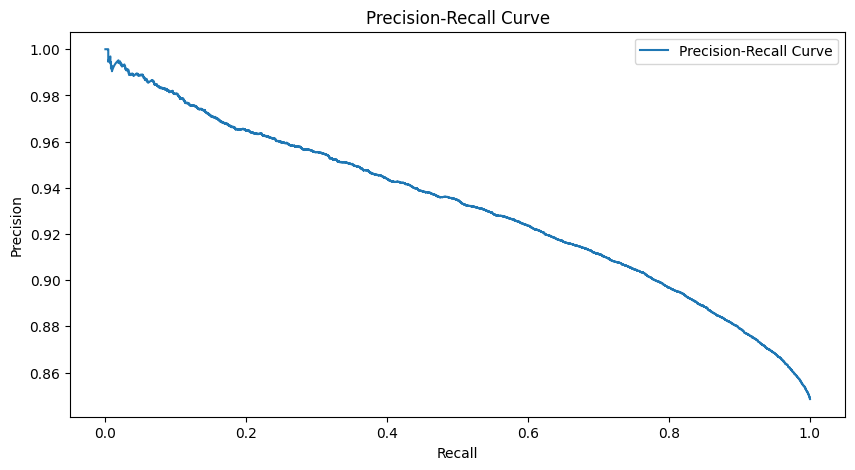

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Cell 2: Focal Loss Implementation
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# Cell 3: Simplified Model Architecture
class SimpleDualTower(nn.Module):
    def __init__(self, tabular_dim, embedding_dim):
        super(SimpleDualTower, self).__init__()
        self.tabular_net = nn.Sequential(
            nn.Linear(tabular_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )
        self.embedding_net = nn.Sequential(
            nn.Linear(embedding_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x_tab, x_emb):
        tab_out = self.tabular_net(x_tab)
        emb_out = self.embedding_net(x_emb)
        combined = torch.cat([tab_out, emb_out], dim=1)
        return self.classifier(combined).squeeze(1)

# Cell 4: Data Preparation (Fixed)
def prepare_data(df, test_size=0.2, val_size=0.1, pca_variance=0.95):
    # Initial split
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        df.drop('status_binary', axis=1),
        df['status_binary'],
        test_size=test_size,
        stratify=df['status_binary'],
        random_state=42
    )

    # Validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=val_size/(1-test_size),
        stratify=y_train_val,
        random_state=42
    )

    # Process embeddings
    train_emb = np.vstack(X_train['cls_embedding'].values)
    val_emb = np.vstack(X_val['cls_embedding'].values)
    test_emb = np.vstack(X_test['cls_embedding'].values)

    # Scale and PCA
    emb_scaler = StandardScaler().fit(train_emb)
    pca = PCA(n_components=pca_variance).fit(emb_scaler.transform(train_emb))

    def process_embeddings(emb):
        return pca.transform(emb_scaler.transform(emb))

    train_emb_pca = process_embeddings(train_emb)
    val_emb_pca = process_embeddings(val_emb)
    test_emb_pca = process_embeddings(test_emb)

    # Process tabular features
    def process_tabular(df_tab):
        df_tab = df_tab.drop('cls_embedding', axis=1)
        bool_cols = df_tab.select_dtypes('bool').columns
        df_tab[bool_cols] = df_tab[bool_cols].astype(int)
        numerical = df_tab.select_dtypes(['int64', 'float64']).columns
        scaler = MinMaxScaler().fit(X_train[numerical])
        df_tab[numerical] = scaler.transform(df_tab[numerical])
        return df_tab.values

    X_train_tab = process_tabular(X_train)
    X_val_tab = process_tabular(X_val)
    X_test_tab = process_tabular(X_test)

    # Apply ADASYN only to training data
    print(f"Initial class distribution: {Counter(y_train)}")
    adasyn = ADASYN(sampling_strategy=0.8, random_state=42)
    X_train_combined, y_train_resampled = adasyn.fit_resample(
        np.hstack([X_train_tab, train_emb_pca]),
        y_train
    )
    print(f"Resampled class distribution: {Counter(y_train_resampled)}")

    # Split back into components
    tab_dim = X_train_tab.shape[1]
    return {
        'train': (
            torch.tensor(X_train_combined[:, :tab_dim], dtype=torch.float32),
            torch.tensor(X_train_combined[:, tab_dim:], dtype=torch.float32),
            torch.tensor(y_train_resampled, dtype=torch.float32)
        ),
        'val': (
            torch.tensor(X_val_tab, dtype=torch.float32),
            torch.tensor(val_emb_pca, dtype=torch.float32),
            torch.tensor(y_val.values, dtype=torch.float32)
        ),
        'test': (
            torch.tensor(X_test_tab, dtype=torch.float32),
            torch.tensor(test_emb_pca, dtype=torch.float32),
            torch.tensor(y_test.values, dtype=torch.float32)
        ),
        'feature_info': {
            'tabular_dim': tab_dim,
            'embedding_dim': train_emb_pca.shape[1]
        }
    }

# Cell 5: Training Utilities
def create_dataloaders(data_dict, batch_size=128):
    return {
        'train': DataLoader(TensorDataset(*data_dict['train']), batch_size=batch_size, shuffle=True),
        'val': DataLoader(TensorDataset(*data_dict['val']), batch_size=batch_size),
        'test': DataLoader(TensorDataset(*data_dict['test']), batch_size=batch_size)
    }

def train_model(data_dict, device, epochs=50, patience=5):
    model = SimpleDualTower(
        data_dict['feature_info']['tabular_dim'],
        data_dict['feature_info']['embedding_dim']
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CyclicLR(
        optimizer, base_lr=1e-5, max_lr=1e-4, step_size_up=500
    )
    criterion = FocalLoss(alpha=0.75, gamma=2.0)

    loaders = create_dataloaders(data_dict)
    best_auc = 0
    no_improve = 0

    for epoch in range(epochs):
        model.train()
        for x_tab, x_emb, y in loaders['train']:
            x_tab, x_emb, y = x_tab.to(device), x_emb.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x_tab, x_emb)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            scheduler.step()

        # Validation
        model.eval()
        val_probs, val_labels = [], []
        with torch.no_grad():
            for x_tab, x_emb, y in loaders['val']:
                x_tab, x_emb = x_tab.to(device), x_emb.to(device)
                val_probs.extend(torch.sigmoid(model(x_tab, x_emb)).cpu().numpy())
                val_labels.extend(y.cpu().numpy())

        val_auc = roc_auc_score(val_labels, val_probs)
        val_preds = np.array(val_probs) > 0.5
        class_0_recall = recall_score(val_labels, val_preds, pos_label=0)

        print(f"Epoch {epoch+1}: Val AUC = {val_auc:.4f}, Class 0 Recall = {class_0_recall:.4f}")

        if val_auc > best_auc:
            best_auc = val_auc
            no_improve = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(torch.load('best_model.pt'))
    return model

# Cell 6: Evaluation and Visualization
def evaluate_model(model, test_loader, device):
    model.eval()
    probs, preds, labels = [], [], []

    with torch.no_grad():
        for x_tab, x_emb, y in test_loader:
            x_tab, x_emb = x_tab.to(device), x_emb.to(device)
            batch_probs = torch.sigmoid(model(x_tab, x_emb)).cpu().numpy()
            probs.extend(batch_probs)
            preds.extend(batch_probs > 0.5)
            labels.extend(y.cpu().numpy())

    # Metrics
    print("Classification Report:")
    print(classification_report(labels, preds))

    print(f"\nROC AUC: {roc_auc_score(labels, probs):.4f}")
    print(f"Average Precision: {average_precision_score(labels, probs):.4f}")

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(labels, probs)
    plt.figure(figsize=(10, 5))
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    return {
        'probs': probs,
        'labels': labels,
        'preds': preds
    }

# Prepare data
print("Preparing data...")
data_dict = prepare_data(df)

# Initialize training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nTraining on {device}")

# Train model
print("\nTraining model...")
model = train_model(data_dict, device)

# Evaluate
print("\nEvaluating model...")
test_loader = create_dataloaders(data_dict)['test']
results = evaluate_model(model, test_loader, device)

In [ ]:
# === Step 1: Prepare Data ===
df_run = df.copy()
desired_ratio = 0.8

# Separate features and target
X_full = df_run.drop(columns=['status_binary', 'cls_embedding'])  # <--- remove cls_embedding entirely
y_full = df_run['status_binary']

# Tabular features only
numerical_features = [col for col in X_full.columns if X_full[col].dtype in [np.float64, np.int64]]
dummy_features = [col for col in X_full.columns if col not in numerical_features]
for col in dummy_features:
    if X_full[col].dtype == 'bool':
        X_full[col] = X_full[col].astype(int)

# Apply MinMaxScaler
tab_scaler = MinMaxScaler()
X_full[numerical_features] = tab_scaler.fit_transform(X_full[numerical_features])

# Final arrays
X_tab_np = X_full.values.astype(np.float32)
y_np = y_full.values.astype(np.float32)

X_tab = torch.tensor(X_tab_np)
y_tensor = torch.tensor(y_np)

# === Step 2: Train-test split ===
X_tab_train, X_tab_test, y_train, y_test = train_test_split(
    X_tab, y_tensor, test_size=0.2, random_state=42, stratify=y_tensor
)

# === Step 3: Oversample ONLY on tabular train ===
X_tab_train_np = X_tab_train.numpy()
y_train_np = y_train.numpy()

ros = RandomOverSampler(sampling_strategy=desired_ratio, random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_tab_train_np, y_train_np)

X_tab_train = torch.tensor(X_resampled, dtype=torch.float32)
y_train = torch.tensor(y_resampled, dtype=torch.float32)

# === Step 4: Validation split ===
X_tab_train, X_tab_val, y_train, y_val = train_test_split(
    X_tab_train, y_train, test_size=0.1, random_state=42
)

# === Step 5: Create DataLoaders ===
train_ds = TensorDataset(X_tab_train, y_train)
val_ds = TensorDataset(X_tab_val, y_val)
test_ds = TensorDataset(X_tab_test, y_test)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

# === Step 6: Define Tabular-Only Model ===
class TabularNN(nn.Module):
    def __init__(self, tabular_input_dim, hidden_dim=128, dropout_rate=0.3):
        super(TabularNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(tabular_input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1)  # no sigmoid
        )

    def forward(self, x_tab):
        return self.net(x_tab).squeeze(1)

# === Step 7: Training ===
model = TabularNN(X_tab.shape[1])
pos_weight = torch.tensor([1.5], dtype=torch.float32)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_auc = 0
epochs_no_improve = 0
patience = 5
best_model_state = None
loss_history = []

for epoch in range(100):
    model.train()
    total_loss = 0
    for x_tab_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_tab_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loss_history.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_probs, val_labels = [], []
    with torch.no_grad():
        for x_tab_val_batch, y_val_batch in val_loader:
            probs = model(x_tab_val_batch).squeeze()
            val_probs.extend(probs.tolist())
            val_labels.extend(y_val_batch.tolist())
    val_auc = roc_auc_score(val_labels, val_probs)
    print(f"Epoch {epoch+1} - Train Loss: {total_loss / len(train_loader):.4f} - Val AUC: {val_auc:.4f}")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

if best_model_state:
    model.load_state_dict(best_model_state)

# === Step 8: Final Evaluation ===
model.eval()
all_preds, all_probs, all_labels = [], [], []
with torch.no_grad():
    for x_tab_batch, y_batch in test_loader:
        logits = model(x_tab_batch)
        probs = torch.sigmoid(logits).squeeze()
        preds = (probs > 0.5).float()
        all_preds.extend(preds.tolist())
        all_probs.extend(probs.tolist())
        all_labels.extend(y_batch.tolist())

print("\n=== Final Evaluation on Test Set ===")
print(classification_report(all_labels, all_preds))
print(f"ROC AUC Score: {roc_auc_score(all_labels, all_probs):.4f}")

Epoch 1 - Train Loss: 0.7510 - Val AUC: 0.7194
Epoch 2 - Train Loss: 0.7367 - Val AUC: 0.7322
Epoch 3 - Train Loss: 0.7287 - Val AUC: 0.7388
Epoch 4 - Train Loss: 0.7237 - Val AUC: 0.7416
Epoch 5 - Train Loss: 0.7191 - Val AUC: 0.7473
Epoch 6 - Train Loss: 0.7154 - Val AUC: 0.7490
Epoch 7 - Train Loss: 0.7131 - Val AUC: 0.7508
Epoch 8 - Train Loss: 0.7102 - Val AUC: 0.7524
Epoch 9 - Train Loss: 0.7081 - Val AUC: 0.7556
Epoch 10 - Train Loss: 0.7070 - Val AUC: 0.7565
Epoch 11 - Train Loss: 0.7043 - Val AUC: 0.7598
Epoch 12 - Train Loss: 0.7026 - Val AUC: 0.7615
Epoch 13 - Train Loss: 0.7004 - Val AUC: 0.7662
Epoch 14 - Train Loss: 0.6996 - Val AUC: 0.7652
Epoch 15 - Train Loss: 0.6989 - Val AUC: 0.7657
Epoch 16 - Train Loss: 0.6971 - Val AUC: 0.7665
Epoch 17 - Train Loss: 0.6957 - Val AUC: 0.7679
Epoch 18 - Train Loss: 0.6944 - Val AUC: 0.7690
Epoch 19 - Train Loss: 0.6936 - Val AUC: 0.7702
Epoch 20 - Train Loss: 0.6930 - Val AUC: 0.7713
Epoch 21 - Train Loss: 0.6917 - Val AUC: 0.7733
E

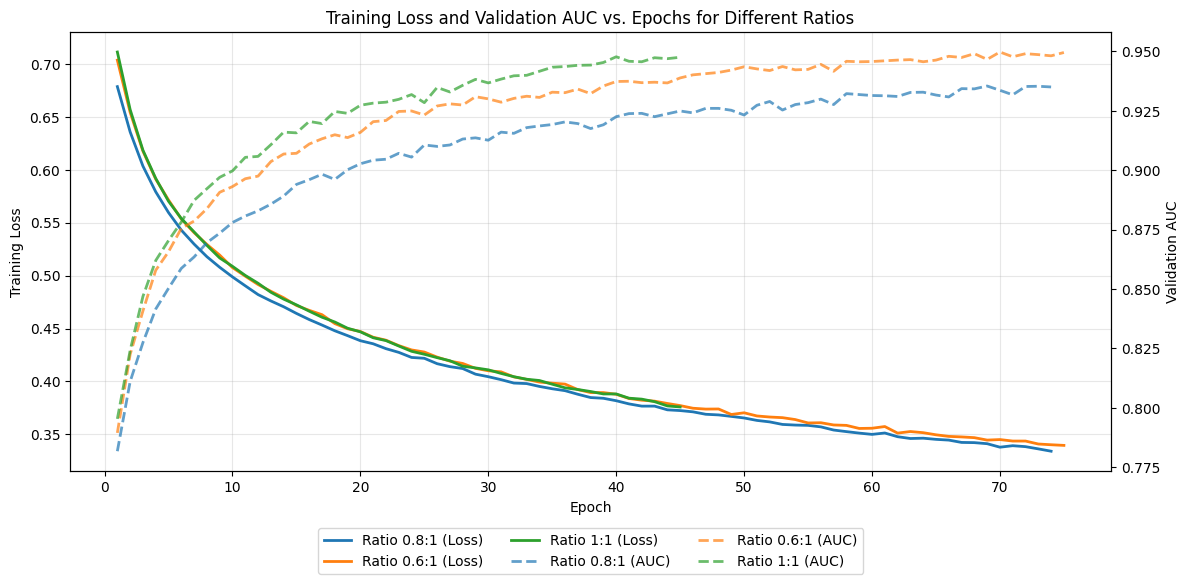

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for each ratio
ratio_data = {
    "0.8:1": {
        "epochs": np.arange(1, 75),
        "train_loss": [
            0.6786, 0.6358, 0.6035, 0.5792, 0.5596, 0.5430, 0.5298, 0.5179, 0.5079, 0.4988,
            0.4904, 0.4821, 0.4761, 0.4706, 0.4643, 0.4585, 0.4533, 0.4479, 0.4433, 0.4385,
            0.4356, 0.4310, 0.4275, 0.4227, 0.4219, 0.4168, 0.4140, 0.4122, 0.4069, 0.4045,
            0.4017, 0.3985, 0.3980, 0.3953, 0.3931, 0.3913, 0.3879, 0.3848, 0.3841, 0.3818,
            0.3788, 0.3767, 0.3767, 0.3732, 0.3725, 0.3713, 0.3690, 0.3684, 0.3670, 0.3655,
            0.3632, 0.3618, 0.3594, 0.3588, 0.3585, 0.3571, 0.3541, 0.3526, 0.3512, 0.3500,
            0.3513, 0.3478, 0.3461, 0.3464, 0.3453, 0.3446, 0.3424, 0.3422, 0.3412, 0.3379,
            0.3393, 0.3384, 0.3363, 0.3341
        ],
        "val_auc": [
            0.7818, 0.8111, 0.8275, 0.8416, 0.8503, 0.8587, 0.8635, 0.8695, 0.8735, 0.8780,
            0.8807, 0.8829, 0.8857, 0.8891, 0.8940, 0.8960, 0.8983, 0.8961, 0.9002, 0.9027,
            0.9042, 0.9046, 0.9071, 0.9055, 0.9106, 0.9100, 0.9106, 0.9131, 0.9136, 0.9126,
            0.9160, 0.9155, 0.9179, 0.9186, 0.9192, 0.9203, 0.9196, 0.9175, 0.9191, 0.9225,
            0.9238, 0.9239, 0.9225, 0.9237, 0.9249, 0.9241, 0.9260, 0.9260, 0.9252, 0.9232,
            0.9273, 0.9289, 0.9253, 0.9276, 0.9284, 0.9299, 0.9276, 0.9322, 0.9318, 0.9314,
            0.9313, 0.9310, 0.9327, 0.9328, 0.9316, 0.9308, 0.9343, 0.9342, 0.9354, 0.9336,
            0.9317, 0.9352, 0.9353, 0.9350
        ]
    },
    "0.6:1": {
        "epochs": np.arange(1, 76),
        "train_loss": [
            0.7036, 0.6543, 0.6176, 0.5912, 0.5715, 0.5535, 0.5406, 0.5295, 0.5194, 0.5076,
            0.4995, 0.4916, 0.4852, 0.4791, 0.4718, 0.4672, 0.4631, 0.4547, 0.4498, 0.4472,
            0.4418, 0.4390, 0.4339, 0.4298, 0.4278, 0.4230, 0.4192, 0.4170, 0.4124, 0.4101,
            0.4091, 0.4043, 0.4020, 0.3994, 0.3984, 0.3975, 0.3923, 0.3895, 0.3895, 0.3879,
            0.3839, 0.3823, 0.3814, 0.3792, 0.3772, 0.3747, 0.3739, 0.3740, 0.3688, 0.3704,
            0.3674, 0.3664, 0.3658, 0.3640, 0.3608, 0.3610, 0.3589, 0.3585, 0.3556, 0.3558,
            0.3574, 0.3512, 0.3527, 0.3516, 0.3496, 0.3481, 0.3476, 0.3469, 0.3446, 0.3451,
            0.3437, 0.3437, 0.3409, 0.3402, 0.3396
        ],
        "val_auc": [
            0.7895, 0.8225, 0.8408, 0.8579, 0.8657, 0.8755, 0.8786, 0.8838, 0.8907, 0.8931,
            0.8964, 0.8975, 0.9036, 0.9068, 0.9071, 0.9110, 0.9132, 0.9149, 0.9137, 0.9159,
            0.9204, 0.9209, 0.9247, 0.9249, 0.9232, 0.9270, 0.9279, 0.9274, 0.9309, 0.9300,
            0.9286, 0.9302, 0.9311, 0.9306, 0.9328, 0.9326, 0.9341, 0.9322, 0.9354, 0.9373,
            0.9374, 0.9368, 0.9370, 0.9367, 0.9388, 0.9401, 0.9406, 0.9411, 0.9421, 0.9435,
            0.9426, 0.9419, 0.9436, 0.9422, 0.9424, 0.9445, 0.9416, 0.9458, 0.9456, 0.9457,
            0.9460, 0.9463, 0.9465, 0.9456, 0.9463, 0.9479, 0.9474, 0.9490, 0.9466, 0.9497,
            0.9477, 0.9490, 0.9486, 0.9481, 0.9495
        ]
    },
    "1:1": {
        "epochs": np.arange(1, 46),
        "train_loss": [
            0.7113, 0.6569, 0.6185, 0.5919, 0.5703, 0.5540, 0.5413, 0.5286, 0.5167, 0.5088,
            0.5002, 0.4928, 0.4843, 0.4778, 0.4724, 0.4664, 0.4607, 0.4562, 0.4503, 0.4469,
            0.4413, 0.4386, 0.4335, 0.4285, 0.4257, 0.4225, 0.4196, 0.4144, 0.4128, 0.4110,
            0.4076, 0.4045, 0.4021, 0.4009, 0.3974, 0.3940, 0.3924, 0.3905, 0.3882, 0.3882,
            0.3842, 0.3833, 0.3809, 0.3769, 0.3759
        ],
        "val_auc": [
            0.7954, 0.8242, 0.8469, 0.8620, 0.8704, 0.8782, 0.8873, 0.8922, 0.8970, 0.8997,
            0.9054, 0.9058, 0.9107, 0.9160, 0.9157, 0.9205, 0.9196, 0.9247, 0.9239, 0.9273,
            0.9282, 0.9286, 0.9298, 0.9318, 0.9284, 0.9348, 0.9329, 0.9357, 0.9382, 0.9367,
            0.9383, 0.9397, 0.9399, 0.9416, 0.9433, 0.9436, 0.9441, 0.9442, 0.9453, 0.9477,
            0.9458, 0.9456, 0.9473, 0.9469, 0.9475
        ]
    }
}

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot training loss on primary axis (left)
for ratio, data in ratio_data.items():
    ax1.plot(data["epochs"], data["train_loss"],
             label=f"Ratio {ratio} (Loss)",
             linestyle='-',
             marker='',
             linewidth=2)

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Training Loss")
ax1.set_title("Training Loss and Validation AUC vs. Epochs for Different Ratios")
ax1.grid(True, alpha=0.3)

# Create secondary axis for AUC
ax2 = ax1.twinx()

# Plot validation AUC on secondary axis (right)
for ratio, data in ratio_data.items():
    ax2.plot(data["epochs"], data["val_auc"],
             label=f"Ratio {ratio} (AUC)",
             linestyle='--',
             marker='',
             linewidth=2,
             alpha=0.7)

ax2.set_ylabel("Validation AUC")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)

plt.tight_layout()
plt.show()

In [ ]:
# Resampling

# Define target ratio
desired_ratio = 1.5

# Count current samples
minority_class_size = df[df['status_binary'] == 0].shape[0]  # 39,929
majority_class_size = df[df['status_binary'] == 1].shape[0]  # 223,519

# Compute new size for majority class
new_majority_size = int(desired_ratio * minority_class_size)

# Downsample majority class
df_majority_downsampled = df[df['status_binary'] == 1].sample(n=new_majority_size, random_state=42)

# Keep all minority class
df_minority = df[df['status_binary'] == 0]

# Combine both
df = pd.concat([df_majority_downsampled, df_minority])
# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(df['status_binary'].value_counts())

In [ ]:
# Stack embeddings into a matrix
embeddings_matrix = np.vstack(df['cls_embedding'].values)

# Standardize embeddings before PCA
scaler = StandardScaler()
embeddings_matrix = scaler.fit_transform(embeddings_matrix)  # Standardize before PCA

# Fit PCA to find the optimal number of components
pca = PCA()
pca.fit(embeddings_matrix)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
optimal_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Optimal number of components: {optimal_components}")

# Apply PCA with optimal components
pca = PCA(n_components=optimal_components)
reduced_embeddings = pca.fit_transform(embeddings_matrix)

# Standardize PCA-transformed embeddings to normalize variance
scaler_pca = StandardScaler()
reduced_embeddings = scaler_pca.fit_transform(reduced_embeddings)

# Store PCA-transformed embeddings in DataFrame
df_pca = pd.DataFrame(reduced_embeddings, columns=[f'pca_emb_{i}' for i in range(optimal_components)])

# Reset index to ensure alignment with original df
df_pca.index = df.index

In [ ]:
from sklearn.feature_selection import SelectFromModel

# === Define Target Variable (Binary Classification) ===
df = df.copy()  # Ensure df isn't modified accidentally
df = df.drop(columns=['cls_embedding'])
# === Separate Features and Target ===
X = df.drop(columns=['status_binary'])
y = df['status_binary']

# === Feature Types ===
numerical_features = [col for col in X.columns if X[col].dtype in [np.float64, np.int64]]
dummy_features = [col for col in X.columns if col not in numerical_features]

# === Convert Boolean Features to Integer ===
X[dummy_features] = X[dummy_features].astype(int)

# === Use df_pca as Embeddings ===
X_emb = pd.concat([X, df_pca], axis=1)

# === Standardize Numerical Features (Ensure embeddings & tabular are on same scale) ===
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])
X_emb[numerical_features] = scaler.transform(X_emb[numerical_features])
X_emb[df_pca.columns] = scaler.fit_transform(X_emb[df_pca.columns])  # Standardize PCA embeddings too

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(X_emb, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# === Feature Selection for Embedding Model ===
def feature_selection(X_train, y_train, X_test):
    xgb_feature_selector = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42)
    xgb_feature_selector.fit(X_train, y_train)

    selector = SelectFromModel(xgb_feature_selector, threshold="mean", prefit=True)
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    selected_features = X_train.columns[selector.get_support()]
    print(f"\nSelected {len(selected_features)} features.")

    return X_train_selected, X_test_selected, selected_features

# === Apply Feature Selection ===
X_train_selected, X_test_selected, selected_features_no_emb = feature_selection(X_train, y_train, X_test)
X_train_emb_selected, X_test_emb_selected, selected_features = feature_selection(X_train_emb, y_train_emb, X_test_emb)

# === Define XGBoost Parameter Grid ===
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

# === Train XGBoost Model ===
def train_xgb(X_train, y_train, X_test, y_test):
    xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
    grid_search = GridSearchCV(xgb_clf, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    # Best Model Performance
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    print("\n=== Best Parameters ===")
    print(grid_search.best_params_)
    print("\n=== Classification Report ===")
    print(classification_report(y_test, y_pred))
    print(f"\nROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

    return best_model

In [ ]:
# === Train and Evaluate Model Without Embeddings ===
print("\n=== Training Model Without Embeddings ===")
xgb_no_emb = train_xgb(X_train_selected, y_train, X_test_selected, y_test)

In [ ]:
# === Train and Evaluate Model With Embeddings (Feature Selection Applied) ===
print("\n=== Training Model With Embeddings (Feature Selection Applied) ===")
xgb_with_emb = train_xgb(X_train_emb_selected, y_train_emb, X_test_emb_selected, y_test_emb)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df = pd.read_parquet('/content/drive/My Drive/clinical trials/trials_pmid_papers_cleaned.parquet')

In [ ]:
df.head()

,protocolSection.identificationModule.nctId,pmid_list,Abstract,is_cancer
0,NCT05713162,"[31231268, 35279764]","[Over the last 20 years, researchers have been...",False
1,NCT05143775,[34599481],[Many patients with glioma experience surgery-...,True
2,NCT01707277,"[22993500, 23918838, 23864363]",[The purpose of this review was to assess the ...,False
3,NCT02953301,[32632956],[Mycosis fungoides (MF) is the most common typ...,True
4,NCT05060471,"[28055103, 23484057, 8348857, 8874455, 2035453...","[Each year, the American Cancer Society estima...",True


In [ ]:
print(df.shape)
print(df['is_cancer'].value_counts())

(135599, 4)
is_cancer
False    110363
True      25236
Name: count, dtype: int64


In [ ]:
# df['is_cancer'] = df['protocolSection.identificationModule.nctId'].isin(df_cancer['NCT Number'])
# df

In [ ]:
df['pmid_list'].apply(type).value_counts()

,count
pmid_list,
<class 'numpy.ndarray'>,136928


In [ ]:
import numpy as np

mask_none_array = df['pmid_list'].apply(lambda x: isinstance(x, np.ndarray) and np.array_equal(x, np.array([None])))
print(f"Rows with [None]: {mask_none_array.sum()}")

Rows with [None]: 1329


In [ ]:
df = df[~mask_none_array].copy()

In [ ]:
df.to_parquet('/content/drive/My Drive/clinical trials/trials_pmid_papers_cleaned.parquet', index=False)

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
import numpy as np

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Flatten all abstracts into one list and count tokens
total_tokens = df['Abstract'].dropna().explode().map(
    lambda x: len(word_tokenize(x)) if isinstance(x, str) else 0
).sum()

print("Total tokens in all abstracts:", total_tokens)

Total tokens in all abstracts: 185551746
Total tokens in rows with multiple abstracts: 0


In [ ]:
import numpy as np
df['Abstract'] = df['Abstract'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

# Filter only rows with more than 1 non-empty string abstract
multi_abstract_df = df[df['Abstract'].apply(
    lambda x: isinstance(x, list) and len([a for a in x if isinstance(a, str) and a.strip()]) > 1
)]

# Count tokens across all abstracts in those rows
multi_abstract_tokens = multi_abstract_df['Abstract'].explode().map(
    lambda x: len(word_tokenize(x)) if isinstance(x, str) and x.strip() else 0
).sum()

print("Total tokens in rows with multiple abstracts:", multi_abstract_tokens)

Total tokens in rows with multiple abstracts: 165366211


In [ ]:
print(185551746 + 165366211)

350917957


In [ ]:
total_tokens_cancer = df[df['is_cancer']]['Abstract'].dropna().explode().map(
    lambda x: len(word_tokenize(x)) if isinstance(x, str) else 0
).sum()

print("Total tokens in all cancer-related abstracts:", total_tokens_cancer)


# Optional: ensure Abstract is list, not np.ndarray
df['Abstract'] = df['Abstract'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

multi_abstract_df_cancer = df[
    df['is_cancer'] &
    df['Abstract'].apply(lambda x: isinstance(x, list) and len([a for a in x if isinstance(a, str) and a.strip()]) > 1)
]

multi_abstract_tokens_cancer = multi_abstract_df_cancer['Abstract'].explode().map(
    lambda x: len(word_tokenize(x)) if isinstance(x, str) and x.strip() else 0
).sum()

print("Total tokens in cancer trials with multiple abstracts:", multi_abstract_tokens_cancer)

Total tokens in all cancer-related abstracts: 30907193
Total tokens in cancer trials with multiple abstracts: 26649657
